In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict

import time
import sys
sys.path.append('../')

from best.mdp import MDP, ParallelMDP
from best.ltl import solve_ltl_cosafe

ROVER_STEPS = 15   # rover num of steps
COPTER_STEPS = 20  # copter num of steps
rover_init = [0, 0]
copter_init = [0, 2, 0]

###### ROVER MODEL (deterministic for now..) ######

n_r = 11  # number of rover states

# Move left
T1_stay = np.diag(np.ones(n_r))

# Move left
T1_west = np.diag(np.ones(n_r-1), -1)
T1_west[0, 0] = 1

# Mover right
T1_east = np.diag(np.ones(n_r-1), 1)
T1_east[n_r-1, n_r-1] = 1


def input_fcn(inp):  # -1, 0, 1
    return inp+1
    
def output_fcn(n):    # -nr/2, ..., nr/2
    return n

rov_x = MDP([T1_west, T1_stay, T1_east], output_name='rx', output_fcn=output_fcn, 
                                input_name='ux', input_fcn=input_fcn)

rov_y = MDP([T1_west, T1_stay, T1_east], output_name='ry', output_fcn=output_fcn, 
                                input_name='uy', input_fcn=input_fcn)

rover = ParallelMDP([rov_x, rov_y])

print rover

Using numpy backend.


MDP: 9 inputs "(ux, uy)" --> 121 outputs "(rx, ry)"


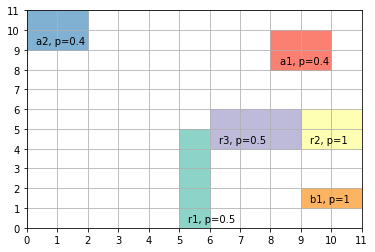

In [2]:
# Define regions
regs = OrderedDict()

def r1(r):
    return r[0] in [5] and r[1] in [0,1,2,3,4]

def r2(r):
    return r[0] in [9,10] and r[1] in [4,5]

def r3(r):
    return r[0] in [6,7,8] and r[1] in [4,5]

def a1(r):
    return r[0] in [8,9] and r[1] in [8, 9]

def a2(r):
    return r[0] in [0,1] and r[1] in [9, 10]

def b1(r):
    return r[0] in [9,10] and r[1] in [1]


regs['r1'] = (r1, 0.5)
regs['r2'] = (r2, 1)
regs['r3'] = (r3, 0.5)
regs['a1'] = (a1, 0.4)
regs['a2'] = (a2, 0.4)
regs['b1'] = (b1, 1)

pinit = [2, 0, 2, 2, 2, 0]

fig = plt.figure()
ax=fig.gca()
ax.set_xticks(np.arange(0, n_r+1, 1))
ax.set_yticks(np.arange(0, n_r+1, 1))
plt.grid()

def plot_region(func, p, color, name):
    text = 0
    for ix in range(n_r):
        for iy in range(n_r):
            if func([ix, iy]):
                ax.add_patch(patches.Rectangle( (ix, iy), 1, 1, color=color ))
                if not text:
                    ax.text(ix+0.3, iy+0.3, '{}, p={}'.format(name, p))
                    text = 1
                
cm = plt.get_cmap('Set3')

i = 0
for (name, info) in regs.iteritems():
    plot_region(info[0], info[1], cm(i), name)
    i += 1

In [3]:
## Environment belief model

def get_mdp(p0, qw, name):
    # Create map belief MDP with prior p0 and qw quality of weak measurements
    if p0 == 0:
        # no dynamics
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 0
    
    elif p0 == 1:
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 1
        
    else:
        pm = p0/2
        pp = p0 + (1-p0)/2
        # levels [0 p- p0 p+ 1]

        Tnone = np.eye(5);
        Tweak = np.array([[1,           0,             0,       0,              0], 
                          [qw*(1-pm),   (1-qw)*(1-pm), 0,       (1-qw)*pm,      qw*pm],
                          [qw*(1-p0),   (1-qw)*p0,     0,       (1-qw)*(1-p0),  qw*p0],
                          [qw*(1-pp),   (1-qw)*(1-pp), 0,       (1-qw)*pp,      qw*pp],
                          [0,           0,             0,       0,              1]])
        Tstrong = np.array([[1,      0, 0, 0, 0],
                            [(1-pm), 0, 0, 0, pm],
                            [(1-p0), 0, 0, 0, p0],
                            [(1-pp), 0, 0, 0, pp],
                            [0,      0, 0, 0, 1]])

        def output_fcn(s):
            return [0, pm, p0, pp, 1][s]
    
    return MDP([Tnone, Tweak, Tstrong], input_name=name+'_u', output_name=name+'_b', output_fcn=output_fcn)

env = ParallelMDP([get_mdp(info[1], 0.1, name) for (name, info) in regs.iteritems()])

print env
print env.N_list

MDP: 729 inputs "(r1_u, r2_u, r3_u, a1_u, a2_u, b1_u)" --> 625 outputs "(r1_b, r2_b, r3_b, a1_b, a2_b, b1_b)"
[5, 1, 5, 5, 5, 1]


In [4]:
## Connect Rover-env

def is_adjacent(func, x):
    # return true x within distance 1 of func
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if func((x[0]+dx, x[1]+dy)):
                return True
    return False

def connection(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_adjacent(info[0], xr):
            ret[i] = 2    # strong measurement
        i += 1
            
    return set([tuple(ret)])

prod_mdp = rover.product(env, connection=connection)
print prod_mdp

MDP: 9 inputs "(ux, uy)" --> 75625 outputs "((rx, ry), (r1_b, r2_b, r3_b, a1_b, a2_b, b1_b))"


In [5]:
## Set up LTL problem

formula = '( ! fail U sampleA ) & ( ! fail U sampleB )'

# map ((rx, ry), (e1, ..., en)) -> 2^2^{sampleA, sampleB, fail}
def ltl_connection(xr_env):
    xr = xr_env[0]
    env = xr_env[1]
    
    i = 0
    
    ret = set([])
    
    for (name, info) in regs.iteritems():
        func = info[0]
        
        if name[0] == 'r' and func(xr) and env[i] > 0:
            # we are in risk reg that is not confirmed safe 
            ret |= set(['fail'])
            
        if name[0] == 'a' and func(xr) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleA'])

        if name[0] == 'b' and func(xr) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleB'])
        i += 1

    return set([tuple(ret)])

print ltl_connection(((9,5), (0,0,0,0,0,1)))
print ltl_connection(((9,5), (0,0.1,0,0,0,0)))

print ltl_connection(((9,1), (0,0,0,0,0,0)))
print ltl_connection(((9,1), (0,0,0,0,0,1)))

set([()])
set([('fail',)])
set([()])
set([('sampleB',)])


In [6]:
pol = solve_ltl_cosafe(prod_mdp, formula, ltl_connection, delta=0.01, maxiter=ROVER_STEPS, verbose=True)

iteration 0, time 7.20024108887e-05
iteration 1, time 7.68010902405
iteration 2, time 12.3696649075
iteration 3, time 17.5672609806
iteration 4, time 22.1950359344
iteration 5, time 26.6750149727
iteration 6, time 31.3442549706
iteration 7, time 36.5086979866
iteration 8, time 41.0599269867
iteration 9, time 45.7901558876
iteration 10, time 50.4373528957
iteration 11, time 55.1371250153
iteration 12, time 60.2708859444
iteration 13, time 64.9816100597
iteration 14, time 69.4501650333
finished after 73.972771883s and 15 iterations


success probability: 0.124


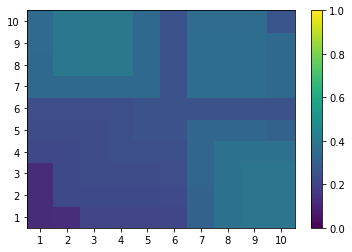

In [7]:
cm = plt.get_cmap('winter')
    
def my_value(x, mapstate):    
   
    s_tot = prod_mdp.global_state( (x, mapstate) )

    _, val = pol.get_input(s_tot)
    return val

fig = plt.figure()
ax=fig.gca()
ax.set_xticks(np.arange(0, n_r+1, 1))
ax.set_yticks(np.arange(0, n_r+1, 1))
plt.grid()
        
x_edge = np.arange(0,n_r)
y_edge = np.arange(0,n_r)

xi, yi = np.meshgrid(x_edge,y_edge)
vals = np.array([my_value((x,y), pinit) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge+0.5, y_edge+0.5, vals.reshape((n_r, n_r)), vmin=0, vmax=1)
plt.colorbar()

print 'success probability: {}'.format(my_value(rover_init, pinit))

In [8]:
# Copter system

n_r = 11  # number of rover states

# Move left
T1_stay = np.diag(np.ones(n_r))

# Move left
T1_west = np.diag(np.ones(n_r-1), -1)
T1_west[0, 0] = 1

# Mover right
T1_east = np.diag(np.ones(n_r-1), 1)
T1_east[n_r-1, n_r-1] = 1

T1_up = np.array([[0, 1], [0, 1]]);
T1_down = np.array([[1, 0], [1, 0]]);

def input_fcn(inp):  # -1, 0, 1
    return inp+1
    
def output_fcn(n):    # -nr/2, ..., nr/2
    return n

cop_x = MDP([T1_west, T1_stay, T1_east], output_name='rx', output_fcn=output_fcn, 
                                input_name='ux', input_fcn=input_fcn)

cop_y = MDP([T1_west, T1_stay, T1_east], output_name='ry', output_fcn=output_fcn, 
                                input_name='uy', input_fcn=input_fcn)

cop_z = MDP([T1_down, T1_up], output_name='rz', output_fcn=output_fcn, 
                              input_name='uy', input_fcn=input_fcn)

copter = ParallelMDP([cop_x, cop_y, cop_z])

print copter

MDP: 18 inputs "(ux, uy, uy)" --> 242 outputs "(rx, ry, rz)"


In [9]:
# connect copter with map
dist = 3

def is_above(func, x):
    # return true x within distance 1 of func
    if func( (x[0], x[1]) ):
        return True
    return False

def is_adjacent(func, x):
    # return true x within distance 1 of func
    for dx in range(-dist, dist+1, 1):
        for dy in range(-dist, dist+1, 1):
            if func((x[0]+dx, x[1]+dy)):
                return True
    return False

def copt_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_above(info[0], xr) and xr[2] == 0:
            ret[i] = 1    # weak measurement
        if is_adjacent(info[0], xr) and xr[2] == 1:
            ret[i] = 2    # strong measurement
        i += 1
        
    return set([tuple(ret)])

mdp_copt_env = copter.product(env, connection=copt_env)
print mdp_copt_env

MDP: 18 inputs "(ux, uy, uy)" --> 151250 outputs "((rx, ry, rz), (r1_b, r2_b, r3_b, a1_b, a2_b, b1_b))"


In [10]:
# Solve problem for copter
def copt_safe(x):
    if x[0] == 0 and x[1] == 2 and x[2] == 0:
        return 1
    else:
        return 0

# value function at time t: rover success probability * copter safe
VT = np.zeros(mdp_copt_env.N_list)
for n in range(copter.N):
    x = copter.output(n)
    if copt_safe(x):
        for m in range(env.N):
            maps = env.local_states(m)
            VT[n, m] = my_value( rover_init, maps )
            
# run value iteration
Vt_list = [VT]

t0 = time.time()
for step in range(COPTER_STEPS):
    print 'step {}, time {}'.format(step, time.time()-t0)

    W_m = mdp_copt_env.sequential_bellman(Vt_list[-1])
    
    Vt_list.append(W_m.max(axis=0))

step 0, time 0.000137090682983
step 1, time 1.24373292923
step 2, time 2.47131299973
step 3, time 3.90846300125
step 4, time 5.01553201675
step 5, time 6.31525802612
step 6, time 7.41287207603
step 7, time 8.50948596001
step 8, time 9.59228086472
step 9, time 10.7292599678
step 10, time 11.9349808693
step 11, time 13.0146720409
step 12, time 14.0765209198
step 13, time 15.2118809223
step 14, time 16.2394759655
step 15, time 17.2942280769
step 16, time 18.3203670979
step 17, time 19.3872900009
step 18, time 20.3977200985
step 19, time 21.4732470512


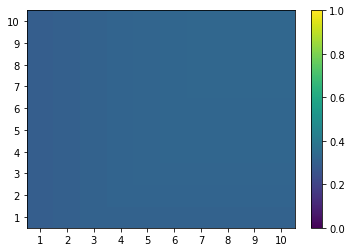

success probability: 0.294172213952


In [11]:
cm = plt.get_cmap('winter')
    
def copter_value(x, mapstate):  
    
    ncop = copter.global_state(x)
    nmap = env.global_state(mapstate)

    return Vt_list[-1][ncop, nmap]

fig = plt.figure()
ax=fig.gca()
ax.set_xticks(np.arange(0, n_r+1, 1))
ax.set_yticks(np.arange(0, n_r+1, 1))
plt.grid()

x_edge = np.arange(0,n_r)
y_edge = np.arange(0,n_r)

xi, yi = np.meshgrid(x_edge,y_edge)
vals = np.array([copter_value((x,y, 0), pinit) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge+0.5, y_edge+0.5, vals.reshape((n_r, n_r)), vmin=0, vmax=1)
plt.colorbar()
plt.show()

print 'success probability: {}'.format(copter_value(copter_init, pinit))